In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Format 2019 - 2022 Historical Data

For the baseline model, we will only use wave related data as features. We have also downloaded ocean current data from the same buoy location, however, we do not want to over over-featurize given the total size of the dataset and MLP model.

Most of the functions in this section format the data text files into dataframes, handle the type conversions, and drop columns we will not use.

In [2]:
def text_to_dataframe(data_path):
    historical_data = pd.read_csv(data_path, delim_whitespace=True, header=0)

    # drop the units row
    units = historical_data.iloc[0]
    historical_data.drop(0, inplace=True)

    # reset the index since we are now missing a row
    historical_data = historical_data.reset_index(drop=True)

    return units, historical_data

There is a little data cleaning we need to do here. As you can see below (where we look at the heads of the dataframes), the values for certain columns are all 99.0 or 9999.0. These values signal a missing value. In the case of our data, the buoy likely does not have the proper instruments to capture these values. To fix this, we will simply drop the columns.

Another issue is that we just loaded in a text file, so all the values in the dataframe are strings. The models we train later in the script need numerical data. We can use some useful functions from the pandas library to convert it to a digestable format for our future model.

To make window slicing easier for the time series data, I only keep measurements on the start of each hour. The original dataframes contain measurements for every 30 minutes. Given that there are marginal changes (from initial observations) every 30 minutes, we only consider inputs that are seperated by one hour of time for the baseline models. We accomplish this with the last function in the block below.

We also drop certain columns to simplify our feature set for the baseline mode. For detailed descriptions of each feature, please refer [here](https://www.ndbc.noaa.gov/faq/measdes.shtml#stdmet).

In [3]:
# TODO: Explain why we are dropping wind direction, wind speed, gust speed, sea level pressure, dewpoint temp, visibility, and tide
def drop_cols(dataframe, columns_to_drop=['WDIR', 'WSPD', 'GST', 'PRES', 'DEWP', 'VIS', 'TIDE']):
    dataframe.drop(columns=columns_to_drop, inplace=True)

def convert_to_numerical_data(dataframe):
    # Convert all columns to numerical values
    dataframe.apply(pd.to_numeric)

    # Convert specific columns to integers
    columns_to_convert_to_int = ['#YY', 'MM', 'DD', 'hh', 'mm']
    for col in columns_to_convert_to_int:
        dataframe[col] = dataframe[col].astype(int)

def convert_to_hourly(dataframe):
    # Drop rows where 'mm' column is not 0
    drop_indices = dataframe[dataframe['mm'] != 0].index
    dataframe.drop(drop_indices, inplace=True)

For each year, we seem to have some missing values (see the smaller number of rows for the dataframe compared to 2020 and 2022). The missing values likely reflect certain times when the sensors of the buoy were malfuncitoning. Because we are dealing with time series data, where datapoints need to be ordered sequentially, we need to account for these missing rows when processing the dataset.

The function below is responsible for finding where the measurement between the ith row and i-1th row is greater than 60 minutes. We will have to account for these rows when preprocessing the data.

Note: We check for 60 minute differences after dropping all measurements that are not taken on the hour! See the other functions below to get a better idea of how we accomplish this.

In [4]:
def check_for_missing_rows(dataframe):
    # Rename columns for compatibility with pd.to_datetime()
    dataframe = dataframe.rename(columns={
        '#YY': 'year',
        'MM': 'month',
        'DD': 'day',
        'hh': 'hour',
        'mm': 'minute'
    })

    # Convert the separate year, month, day, hour, minute columns into a single datetime column
    dataframe['datetime'] = pd.to_datetime(dataframe[['year', 'month', 'day', 'hour', 'minute']])

    missing_indices = []

    # Iterate over rows and check for a time difference of more than 30 minutes
    for i in range(1, dataframe.shape[0]):
        time_diff = dataframe.iloc[i]['datetime'] - dataframe.iloc[i-1]['datetime']
        if time_diff > pd.Timedelta(minutes=60):
            missing_indices.append(i)

    return missing_indices

Now, we need to split the data into time series training and label targets. 

For this step, we need to decide our forecasting window. Given that we are attempting to build an open source wave forecasting model for surfers, we will aim to predict the mean significant wave height in 24-48 hours.

Let's start with a 24 hour lead time. With this decided, we can format a dataset for supervised learning. Our x's will be vectors containg the set of features we specify measured at each hour for a certain amount hours. In the code below, we have 4 features measured at each hour for 24 hours. Thus, each x_i will be 96 x 1 ((4 * 24) x 1). The corresponding label will just be a scalar representing the 'WVHT' value 24 hours ahead of the last hour measurements were taken in the x_i vector.

In [5]:
# TODO: Increase lead to 48 / 96
# TODO: Discuss why wave height, dominant wave period, average wave period, and wave direction are the features we are using
def build_supervised_learning_dataset(dataframe, missing_indices, feature_set=['WVHT', 'DPD', 'APD', 'MWD'], window=24, lead=24):
    # Convert missing_indices to a set for faster lookup
    missing_set = set(missing_indices)

    X, y = [], []

    for i in range(dataframe.shape[0] - window - lead + 1):
        # Check if any of the indices in the current slice are in the missing set
        if any([(i + j) in missing_set for j in range(window)]):
            continue
        
        # Here we grab the window of values for each feature
        x_i = dataframe.iloc[i : i + window][feature_set].to_numpy()

        # Reshape the array so it can be a row vector of X (1 X 24 * 4) -> (1 x 96)
        x_i = x_i.flatten()

        # Only fetch the significant wave height value for the label
        y_i = dataframe.iloc[i + window + lead - 1]['WVHT']

        X.append(x_i)
        y.append(y_i)

    return np.array(X), np.array(y)

### Generalized Data Preprocessing

In [6]:
DATA_PATH_2022 = '../data/targetstation46240/46240h2022.txt'
DATA_PATH_2021 = '../data/targetstation46240/46240h2021.txt'
DATA_PATH_2020 = '../data/targetstation46240/46240h2020.txt'
DATA_PATH_2019 = '../data/targetstation46240/46240h2019.txt'
DATA_PATH_2018 = '../data/targetstation46240/46240h2018.txt'
DATA_PATH_2017 = '../data/targetstation46240/46240h2017.txt'
DATA_PATH_2016 = '../data/targetstation46240/46240h2016.txt'
DATA_PATH_2015 = '../data/targetstation46240/46240h2015.txt'
DATA_PATH_2014 = '../data/targetstation46240/46240h2014.txt'
DATA_PATH_2013 = '../data/targetstation46240/46240h2013.txt'
DATA_PATH_2012 = '../data/targetstation46240/46240h2012.txt'
DATA_PATH_2011 = '../data/targetstation46240/46240h2011.txt'
DATA_PATH_2010 = '../data/targetstation46240/46240h2010.txt'
DATA_PATH_2009 = '../data/targetstation46240/46240h2009.txt'

buoy_datapaths = [DATA_PATH_2016, DATA_PATH_2017, DATA_PATH_2018, DATA_PATH_2019, DATA_PATH_2020, DATA_PATH_2021, DATA_PATH_2022]
station46240specs = ['WVHT', 'DPD', 'APD', 'MWD', 'WTMP']

all_historical_data = []
for datapath in buoy_datapaths:
    _, historical_data = text_to_dataframe(datapath)
    all_historical_data.append(historical_data)

all_historical_data_df = pd.concat(all_historical_data, axis=0).reset_index(drop=True)

drop_cols(all_historical_data_df, columns_to_drop=['WDIR', 'WSPD', 'GST', 'PRES', 'ATMP', 'DEWP', 'VIS', 'TIDE'])
convert_to_numerical_data(all_historical_data_df)
# convert_to_hourly(all_historical_data_df)
missing_indices = check_for_missing_rows(all_historical_data_df)
X, y = build_supervised_learning_dataset(all_historical_data_df, missing_indices, feature_set=station46240specs)
all_historical_data_df

,#YY,MM,DD,hh,mm,WVHT,DPD,APD,MWD,WTMP
0,2016,1,1,0,19,0.84,11.76,7.31,346,12.4
1,2016,1,1,0,49,0.76,11.76,6.82,352,12.4
2,2016,1,1,1,19,0.74,11.76,6.83,349,12.4
3,2016,1,1,2,19,0.71,11.11,5.98,348,12.4
4,2016,1,1,2,49,0.78,12.50,6.45,345,12.4
...,...,...,...,...,...,...,...,...,...,...
115939,2022,12,31,21,56,1.21,11.76,9.90,348,13.3
115940,2022,12,31,22,26,1.26,11.76,10.08,348,13.3
115941,2022,12,31,22,56,1.33,12.50,10.61,349,13.3
115942,2022,12,31,23,26,1.23,11.11,10.25,346,13.3




# Visualizing Historical Data

To increase the number of datapoints we have for the baseline, we will aggregate data recorded by the same buoy for 2020, 2021, and 2022. In the future, we will increase the number of years we aggregate data accross to increase the size of the training set.

Before we get into processing the data into training, dev, and test sets, let's visualize the different feature columns. By examining their distributions, we can make more informed decisions for out data prepocessing steps and model architecture.

In [7]:
buoy_datapaths = [DATA_PATH_2016, DATA_PATH_2017, DATA_PATH_2018, DATA_PATH_2019, DATA_PATH_2020, DATA_PATH_2021, DATA_PATH_2022]
station46240specs = ['WVHT', 'DPD', 'APD', 'MWD', 'WTMP']

all_historical_data = []
for datapath in buoy_datapaths:
    _, historical_data = text_to_dataframe(datapath)
    all_historical_data.append(historical_data)

all_historical_data_df = pd.concat(all_historical_data, axis=0).reset_index(drop=True)

drop_cols(all_historical_data_df, columns_to_drop=['WDIR', 'WSPD', 'GST', 'PRES', 'ATMP', 'DEWP', 'VIS', 'TIDE'])
convert_to_numerical_data(all_historical_data_df)
# convert_to_hourly(all_historical_data_df)
missing_indices = check_for_missing_rows(all_historical_data_df)
X, y = build_supervised_learning_dataset(all_historical_data_df, missing_indices, feature_set=station46240specs)
all_historical_data_df

,#YY,MM,DD,hh,mm,WVHT,DPD,APD,MWD,WTMP
0,2016,1,1,0,19,0.84,11.76,7.31,346,12.4
1,2016,1,1,0,49,0.76,11.76,6.82,352,12.4
2,2016,1,1,1,19,0.74,11.76,6.83,349,12.4
3,2016,1,1,2,19,0.71,11.11,5.98,348,12.4
4,2016,1,1,2,49,0.78,12.50,6.45,345,12.4
...,...,...,...,...,...,...,...,...,...,...
115939,2022,12,31,21,56,1.21,11.76,9.90,348,13.3
115940,2022,12,31,22,26,1.26,11.76,10.08,348,13.3
115941,2022,12,31,22,56,1.33,12.50,10.61,349,13.3
115942,2022,12,31,23,26,1.23,11.11,10.25,346,13.3


In [8]:
# File paths for the provided files
file_paths = [DATA_PATH_2009,DATA_PATH_2010, DATA_PATH_2011, DATA_PATH_2012, DATA_PATH_2013, 
              DATA_PATH_2014, DATA_PATH_2015, DATA_PATH_2016, DATA_PATH_2017, DATA_PATH_2018, 
              DATA_PATH_2019, DATA_PATH_2020, DATA_PATH_2021, DATA_PATH_2022]

def process_file_to_hourly_last(file_path):
    data = pd.read_csv(file_path, delim_whitespace=True, skiprows=1)
    data.columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'TIDE']
    data['datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    
    # Removing the minute component from the datetime
    data['datetime'] = data['datetime'].apply(lambda dt: dt.replace(minute=0))
    # Dropping the 'Minute' column
    data.drop(columns=['Minute'], inplace=True)
    
    # Setting the datetime as the index
    data.set_index('datetime', inplace=True)
    
    # Replace outlier values
    outlier_values = [99, 999, 9999]
    for column in data.columns:
        if data[column].dtype in [float, int]:
            data[column] = data[column].replace(outlier_values, np.nan)

    # Keeping only the last entry for each hour
    data_hourly_last = data.groupby(data.index).last()

    return data_hourly_last


# Re-reading and combining data from all files with outliers replaced by NaN
all_data_46240 = pd.concat([process_file_to_hourly_last(file) for file in file_paths])

all_data_46240

,Year,Month,Day,Hour,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
datetime,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,2009,1,1,0,NaN,NaN,NaN,1.12,11.76,7.91,352.0,NaN,NaN,11.9,NaN,NaN,NaN
2009-01-01 01:00:00,2009,1,1,1,NaN,NaN,NaN,1.02,10.53,6.31,346.0,NaN,NaN,11.9,NaN,NaN,NaN
2009-01-01 02:00:00,2009,1,1,2,NaN,NaN,NaN,1.07,11.11,5.61,352.0,NaN,NaN,11.9,NaN,NaN,NaN
2009-01-01 03:00:00,2009,1,1,3,NaN,NaN,NaN,1.14,11.76,5.42,352.0,NaN,NaN,11.9,NaN,NaN,NaN
2009-01-01 04:00:00,2009,1,1,4,NaN,NaN,NaN,1.00,13.33,5.65,359.0,NaN,NaN,11.9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,2022,12,31,19,NaN,NaN,NaN,1.19,10.53,9.75,341.0,NaN,NaN,13.3,NaN,NaN,NaN
2022-12-31 20:00:00,2022,12,31,20,NaN,NaN,NaN,1.37,11.11,10.35,345.0,NaN,NaN,13.3,NaN,NaN,NaN
2022-12-31 21:00:00,2022,12,31,21,NaN,NaN,NaN,1.21,11.76,9.90,348.0,NaN,NaN,13.3,NaN,NaN,NaN


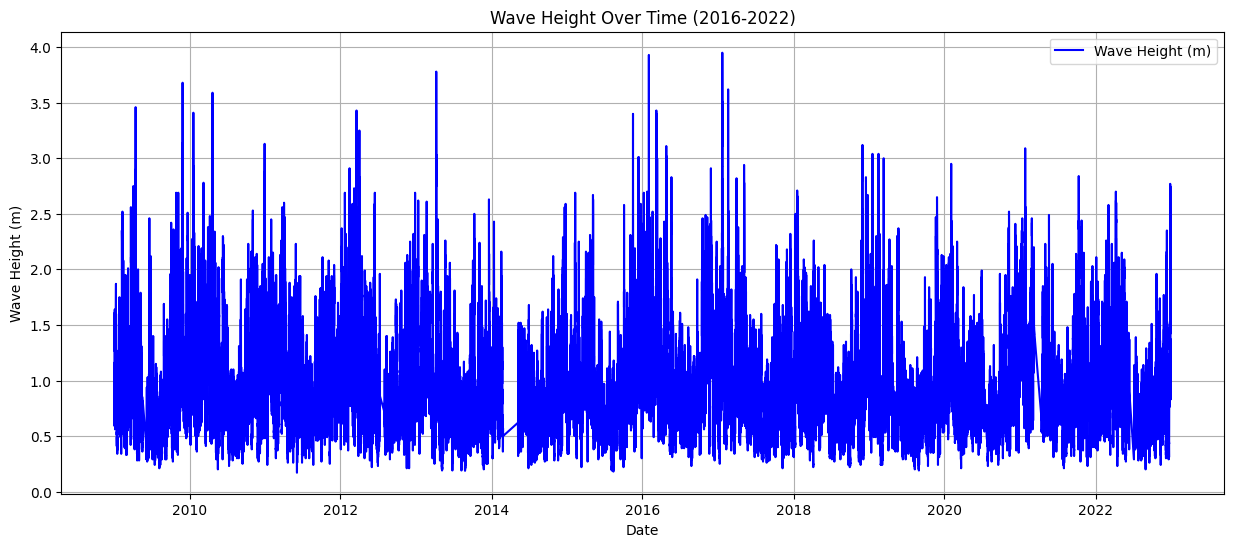

In [9]:
# Plotting the wave height (WVHT) data from the combined dataset
plt.figure(figsize=(15, 6))
plt.plot(all_data_46240.index, all_data_46240['WVHT'], label='Wave Height (m)', color='blue')
plt.title('Wave Height Over Time (2016-2022)')
plt.xlabel('Date')
plt.ylabel('Wave Height (m)')
plt.legend()
plt.grid(True)
plt.show()

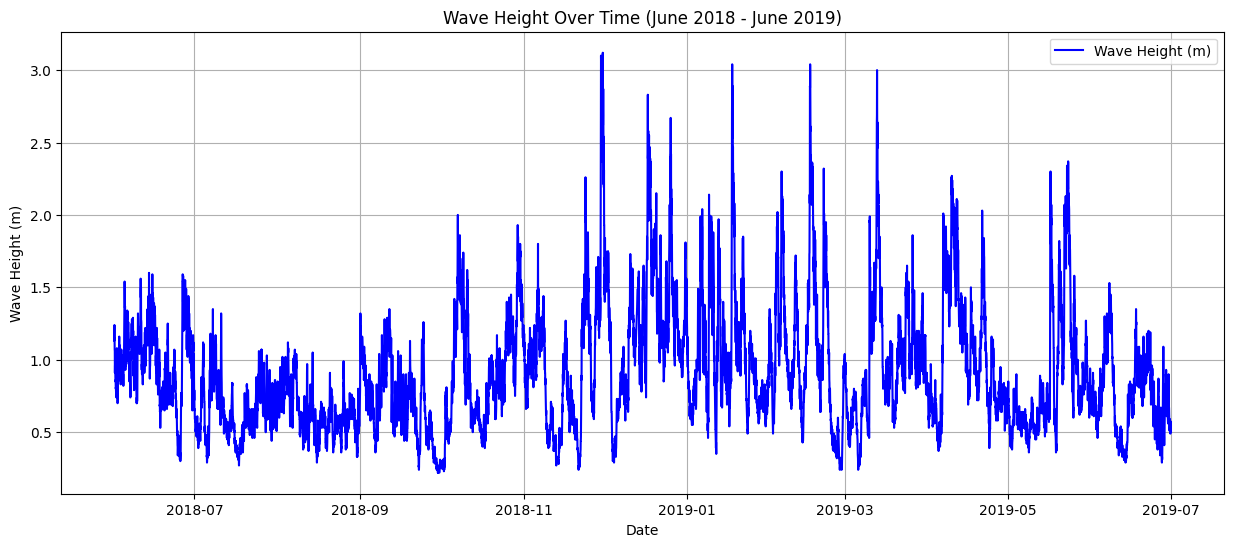

In [10]:
# Filtering the dataset for the period from June 2018 to June 2019 (to see changes in the seasons)
start_date = '2018-06-01'
end_date = '2019-06-30'
filtered_data = all_data_46240.loc[start_date:end_date]

# Plotting the wave height (WVHT) data for the specified period
plt.figure(figsize=(15, 6))
plt.plot(filtered_data.index, filtered_data['WVHT'], label='Wave Height (m)', color='blue')
plt.title('Wave Height Over Time (June 2018 - June 2019)')
plt.xlabel('Date')
plt.ylabel('Wave Height (m)')
plt.legend()
plt.grid(True)
plt.show()

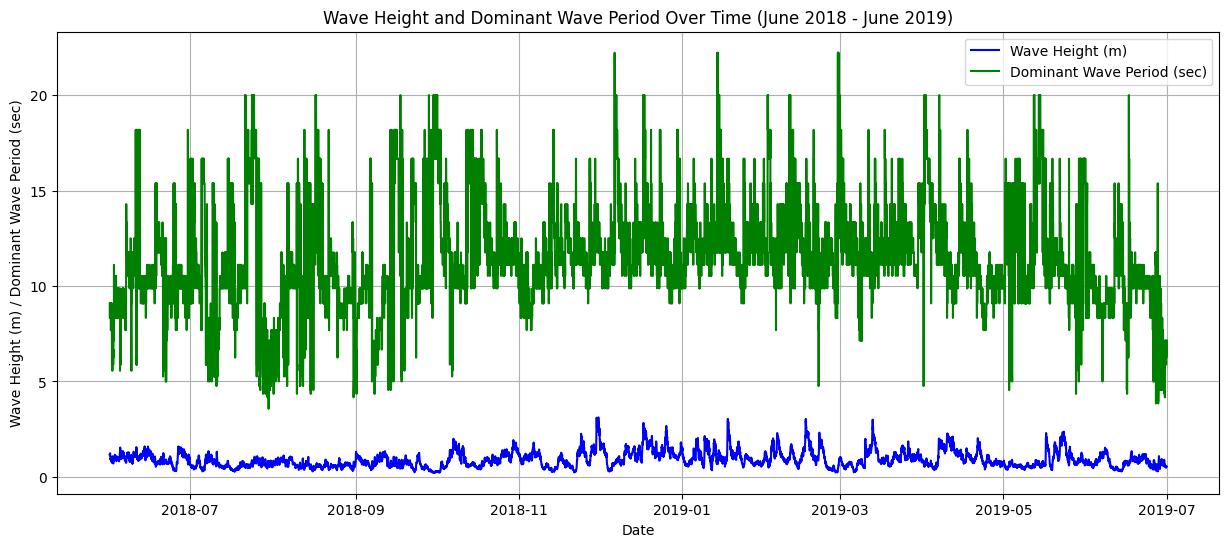

In [11]:
plt.figure(figsize=(15, 6))

# Plotting Wave Height (WVHT)
plt.plot(filtered_data.index, filtered_data['WVHT'], label='Wave Height (m)', color='blue')

# Plotting Dominant Wave Period (DPD)
plt.plot(filtered_data.index, filtered_data['DPD'], label='Dominant Wave Period (sec)', color='green')

# Setting the title and labels
plt.title('Wave Height and Dominant Wave Period Over Time (June 2018 - June 2019)')
plt.xlabel('Date')
plt.ylabel('Wave Height (m) / Dominant Wave Period (sec)')

# Adding a legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

### Adding data from other buoys

Our buoy only has access to wave height, DPD, and APD, but there are other factors that contribute greatly to wave height, namely wind direction and wind speed. So, we will take data from another nearby buoy (Station 46092) that has data specifically for wind and water temperature. First, we will extract the features from this buoy and add them to a new dataframe.

In [12]:
WIND_DATA_2022 = '../data/windstation46092/46092h2022.txt'
WIND_DATA_2021 = '../data/windstation46092/46092h2021.txt'
WIND_DATA_2020 = '../data/windstation46092/46092h2020.txt'
WIND_DATA_2019 = '../data/windstation46092/46092h2019.txt'
WIND_DATA_2018 = '../data/windstation46092/46092h2018.txt'
WIND_DATA_2017 = '../data/windstation46092/46092h2017.txt'
WIND_DATA_2016 = '../data/windstation46092/46092h2016.txt'
WIND_DATA_2015 = '../data/windstation46092/46092h2015.txt'
WIND_DATA_2014 = '../data/windstation46092/46092h2014.txt'
WIND_DATA_2013 = '../data/windstation46092/46092h2013.txt'
WIND_DATA_2012 = '../data/windstation46092/46092h2012.txt'
WIND_DATA_2011 = '../data/windstation46092/46092h2011.txt'
WIND_DATA_2010 = '../data/windstation46092/46092h2010.txt'
WIND_DATA_2009 = '../data/windstation46092/46092h2009.txt'

file_paths_46092 = [WIND_DATA_2009, WIND_DATA_2010, WIND_DATA_2011, WIND_DATA_2012, WIND_DATA_2013, 
                    WIND_DATA_2014, WIND_DATA_2015, WIND_DATA_2016, WIND_DATA_2017, WIND_DATA_2018,
                    WIND_DATA_2019, WIND_DATA_2020, WIND_DATA_2021, WIND_DATA_2022]

all_data_46092 = pd.concat([process_file_to_hourly_last(file) for file in file_paths_46092])
# Anomaly: 2009 contains Dec 31 2008
first_row_index = all_data_46092.index[0]  # Get the index of the first row
all_data_46092 = all_data_46092.drop(first_row_index)  # Drop the first row

all_data_46092

,Year,Month,Day,Hour,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
datetime,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,2009,1,1,0,290.0,9.3,NaN,NaN,NaN,NaN,NaN,1020.5,8.7,12.0,NaN,NaN,NaN
2009-01-01 01:00:00,2009,1,1,1,290.0,10.3,NaN,NaN,NaN,NaN,NaN,1020.3,8.9,11.9,NaN,NaN,NaN
2009-01-01 02:00:00,2009,1,1,2,280.0,9.3,NaN,NaN,NaN,NaN,NaN,1020.4,9.1,11.9,NaN,NaN,NaN
2009-01-01 03:00:00,2009,1,1,3,300.0,7.7,NaN,NaN,NaN,NaN,NaN,1020.9,9.7,11.9,NaN,NaN,NaN
2009-01-01 04:00:00,2009,1,1,4,330.0,6.2,NaN,NaN,NaN,NaN,NaN,1020.6,9.1,11.9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,2022,12,31,19,160.0,12.9,NaN,NaN,NaN,NaN,NaN,1006.7,13.6,13.2,NaN,NaN,NaN
2022-12-31 20:00:00,2022,12,31,20,150.0,13.4,NaN,NaN,NaN,NaN,NaN,1004.4,13.8,13.2,NaN,NaN,NaN
2022-12-31 21:00:00,2022,12,31,21,150.0,13.9,NaN,NaN,NaN,NaN,NaN,1002.8,13.8,13.2,NaN,NaN,NaN


Next, we will merge our wind buoy with our shore wave buoy to get a comprehensive dataset that has all of the factors that we need.

In [14]:
# Merge the two DataFrames on the 'datetime' column
merged_df = all_data_46240.merge(all_data_46092, on='datetime', how='inner')

final_df = merged_df.reset_index()
# Selecting and renaming columns
final_df = final_df[['datetime', 'WVHT_x', 'DPD_x', 'APD_x', 'MWD_x', 'WDIR_y', 'WSPD_y', 'PRES_y', 'ATMP_y', 'WTMP_y']].copy()
final_df.columns = ['datetime', 'WVHT', 'DPD', 'APD', 'MWD', 'WDIR', 'WSPD', 'PRES', 'ATMP', 'WTMP']
final_df.set_index('datetime', inplace=True)

# Calculate the mean for each column
column_means = final_df.mean()

# Fill NaNs with the mean of their respective column
final_df.fillna(column_means, inplace=True)

# Check if there are any NaNs left
print(final_df.isna().any())

final_df

WVHT    False
DPD     False
APD     False
MWD     False
WDIR    False
WSPD    False
PRES    False
ATMP    False
WTMP    False
dtype: bool


,WVHT,DPD,APD,MWD,WDIR,WSPD,PRES,ATMP,WTMP
datetime,,,,,,,,,
2009-01-01 00:00:00,1.12,11.76,7.91,352.0,290.0,9.3,1020.5,8.7,12.0
2009-01-01 01:00:00,1.02,10.53,6.31,346.0,290.0,10.3,1020.3,8.9,11.9
2009-01-01 02:00:00,1.07,11.11,5.61,352.0,280.0,9.3,1020.4,9.1,11.9
2009-01-01 03:00:00,1.14,11.76,5.42,352.0,300.0,7.7,1020.9,9.7,11.9
2009-01-01 04:00:00,1.00,13.33,5.65,359.0,330.0,6.2,1020.6,9.1,11.9
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,1.19,10.53,9.75,341.0,160.0,12.9,1006.7,13.6,13.2
2022-12-31 20:00:00,1.37,11.11,10.35,345.0,150.0,13.4,1004.4,13.8,13.2
2022-12-31 21:00:00,1.21,11.76,9.90,348.0,150.0,13.9,1002.8,13.8,13.2


# Baseline Model Training

For now, we will hold out all of the year 2022 as our test set for our final model. Our features for our X will be dominant wave period (DPD), average wave period (APD), mean wave direction (MWD), wind direction (WDIR), wind speed (WSPD), sea level pressure (PRES), air temperature (ATMP), and sea surface temperature (WTMP).

In [15]:
train_df = final_df[final_df.index.year <= 2021]
test_df = final_df[final_df.index.year == 2022]

X_train = train_df.drop('WVHT', axis=1)
y_train = train_df['WVHT']

X_test = test_df.drop('WVHT', axis=1)
y_test = test_df['WVHT']

print(f'X train shape: {X_train.shape} y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape} y test shape: {y_test.shape}')


# Scale data?
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X train shape: (83720, 8) y train shape: (83720,)
X test shape: (7755, 8) y test shape: (7755,)


For our baseline model, we will be building a simple MLP regression model with the PyTorch Library.

In [16]:
class WaveForecastMLP(nn.Module):
    def __init__(self):
        super(WaveForecastMLP, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(8, 128),  # 8 features, 24 hours
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

In [17]:
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_np)
y_train_tensor = torch.FloatTensor(y_train_np)
X_val_tensor = torch.FloatTensor(X_test_np)
y_val_tensor = torch.FloatTensor(y_test_np)

print("Training data shape:", X_train_tensor.shape)
print("Validation data shape:", X_val_tensor.shape)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

Training data shape: torch.Size([83720, 8])
Validation data shape: torch.Size([7755, 8])


In [18]:
model = WaveForecastMLP()
criterion = torch.nn.MSELoss()  # Mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4, lr=0.00001) # added in weight regularization

Epoch: 1/150 - Train Loss: 0.5952 - Val Loss: 0.1575
Epoch: 10/150 - Train Loss: 0.1495 - Val Loss: 0.1143
Epoch: 20/150 - Train Loss: 0.1206 - Val Loss: 0.0919
Epoch: 30/150 - Train Loss: 0.1130 - Val Loss: 0.0824
Epoch: 40/150 - Train Loss: 0.1110 - Val Loss: 0.0837
Epoch: 50/150 - Train Loss: 0.1098 - Val Loss: 0.0834
Epoch: 60/150 - Train Loss: 0.1097 - Val Loss: 0.0843
Epoch: 70/150 - Train Loss: 0.1093 - Val Loss: 0.0815
Epoch: 80/150 - Train Loss: 0.1084 - Val Loss: 0.0806
Epoch: 90/150 - Train Loss: 0.1077 - Val Loss: 0.0809
Epoch: 100/150 - Train Loss: 0.1073 - Val Loss: 0.0811
Epoch: 110/150 - Train Loss: 0.1065 - Val Loss: 0.0858
Epoch: 120/150 - Train Loss: 0.1063 - Val Loss: 0.0763
Epoch: 130/150 - Train Loss: 0.1058 - Val Loss: 0.0792
Epoch: 140/150 - Train Loss: 0.1056 - Val Loss: 0.0776
Epoch: 150/150 - Train Loss: 0.1052 - Val Loss: 0.0777


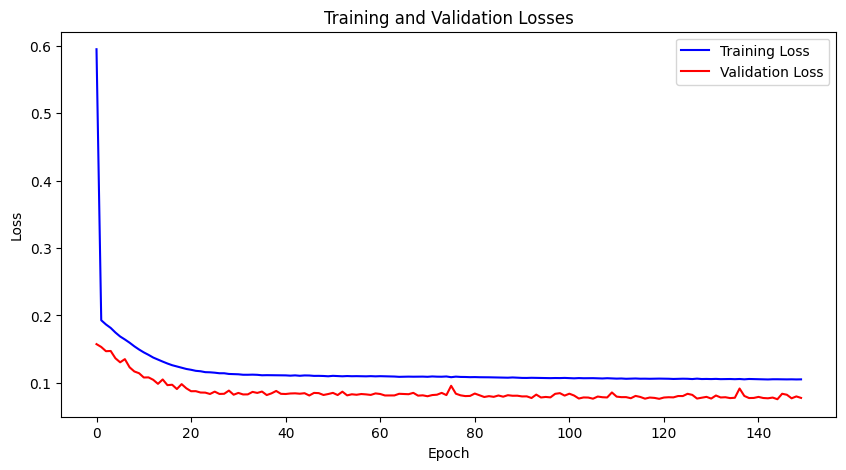

In [19]:
import matplotlib.pyplot as plt

# 1. Initialize Lists for Storing Losses
train_losses = []
val_losses = []

n_epochs = 150
print_every = 10  # Print results every 10 epochs

for epoch in range(1, n_epochs+1):
    # Training
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Evaluation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            predictions = model(X_batch)
            loss = criterion(predictions.squeeze(), y_batch)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # 2. Append Losses to Lists during Training
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Print results
    if epoch == 1 or epoch % print_every == 0:
        print(f'Epoch: {epoch}/{n_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}')

# 3. Plot Losses after Training
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# LSTM Model Training

In [21]:
from sklearn.preprocessing import MinMaxScaler

def create_sequences(dataframe, target_column, sequence_length=48):
    """
    Create sequences from the provided DataFrame.

    :param dataframe: pandas DataFrame containing the time series data.
    :param target_column: The name of the column to be predicted.
    :param sequence_length: The length of the input sequences (number of time steps).
    :return: A tuple of numpy arrays (X, y) where X is the sequences and y is the target values.
    """
    # Normalizing all columns except the target
    scaler = MinMaxScaler()
    feature_columns = [col for col in dataframe.columns if col != target_column]
    dataframe[feature_columns] = scaler.fit_transform(dataframe[feature_columns])

    X, y = [], []
    for i in range(len(dataframe) - sequence_length):
        sequence = dataframe.iloc[i:i + sequence_length][feature_columns]
        target = dataframe.iloc[i + sequence_length][target_column]
        X.append(sequence)
        y.append(target)

    return np.array([sequence.values for sequence in X]), np.array(y)

# Creating sequences from the DataFrame
sequence_length = 48  # 48 hours
X, y = create_sequences(final_df, 'WVHT', sequence_length)

# Displaying the shape of the created sequences and targets
X.shape, y.shape

((91427, 48, 8), (91427,))

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam

def build_lstm_model(input_shape):
    """
    Build an LSTM model for time series prediction.

    :param input_shape: Shape of the input data (sequence_length, num_features).
    :return: Compiled Keras model.
    """
    model = Sequential()
    
    # Adding the first LSTM layer
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    # Adding a second LSTM layer
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))

    # Adding a dense layer with one neuron for output
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Building the model
input_shape = (X.shape[1], X.shape[2])  # 48 hours, 6 features
lstm_model = build_lstm_model(input_shape)

# Model summary
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 48, 50)            11800     
                                                                 
 dropout_2 (Dropout)         (None, 48, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32051 (125.20 KB)
Trainable params: 32051 (125.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# The 'history' object contains training and validation loss for each epoch


Epoch 1/50
2286/2286 [==============================] - 34s 15ms/step - loss: 0.1110 - val_loss: 0.0851
Epoch 2/50
2286/2286 [==============================] - 33s 14ms/step - loss: 0.0840 - val_loss: 0.0696
Epoch 3/50
2286/2286 [==============================] - 33s 15ms/step - loss: 0.0732 - val_loss: 0.0664
Epoch 4/50
2286/2286 [==============================] - 33s 15ms/step - loss: 0.0675 - val_loss: 0.0630
Epoch 5/50
2286/2286 [==============================] - 34s 15ms/step - loss: 0.0631 - val_loss: 0.0570
Epoch 6/50
2286/2286 [==============================] - 33s 14ms/step - loss: 0.0595 - val_loss: 0.0571
Epoch 7/50
2286/2286 [==============================] - 33s 15ms/step - loss: 0.0564 - val_loss: 0.0508
Epoch 8/50
2286/2286 [==============================] - 34s 15ms/step - loss: 0.0555 - val_loss: 0.0490
Epoch 9/50
2286/2286 [==============================] - 33s 14ms/step - loss: 0.0528 - val_loss: 0.0484
Epoch 10/50
2286/2286 [==============================] - 33s 14m

KeyboardInterrupt: 